In [1]:
import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Importing our own functions
import standardize_datasets
from utils import confusion_matrix_improved

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from tqdm import tqdm

In [13]:
from pympler import summary, muppy

In [14]:
allObjects = muppy.get_objects()
sum1 = summary.summarize(allObjects)
summary.print_(sum1)


                        types |   # objects |   total size
============================= | =========== | ============
    pandas.core.series.Series |           4 |    742.87 MB
  pandas.core.frame.DataFrame |           2 |    421.97 MB
                          str |      359906 |     58.61 MB
                         dict |      123770 |     39.36 MB
                         code |       90193 |     15.29 MB
                         type |       12923 |     11.35 MB
                        tuple |       98768 |      5.51 MB
                numpy.ndarray |         140 |      4.00 MB
                         list |       31821 |      3.95 MB
                          set |        4828 |      2.87 MB
                      weakref |       21372 |      1.47 MB
                  abc.ABCMeta |        1279 |      1.31 MB
                         cell |       31831 |      1.21 MB
            getset_descriptor |       15001 |    937.56 KB
   builtin_function_or_method |       13282 |    933.89 

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_embedding = hub.load(module_url)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-22 17:22:41.967163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-22 17:22:41.967271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-22 17:22:44.170345: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-22 17:22:44.228563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Get the dataset

In [3]:
df = standardize_datasets.get_merge_dataset()
df.head()

,article,headline,label
0,David Cameron is being urged to respond to a r...,PM urged to reopen free movement discussion if...,1
1,Now the UK supermarkets know Amazon is coming ...,"Whole Foods, then a whole industry? Amazon sin...",1
2,The Science &amp; Tech feature (“What if virtu...,"If we’re in a simulation, why bother doing any...",1
3,London Irish’s 20-year membership of English r...,Luke Narraway vows to fight as London Irish aw...,1
4,Beekeepers in the Northeast have reported seei...,Northeast Sees Rise Of Mutant ‘Zombie’ Bees,0


In [4]:
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['article'], df['label'], test_size=0.2, random_state=42)

In [5]:
len(X_train), len(X_test)

(57653, 14414)

# Classification using similarity between sentence embeddings

In [6]:
false_sent = np.array(X_train[y_train == 0].values[:1000])
true_sent = np.array(X_train[y_train == 1].values[:1000])

false_sent_embeddings = model_embedding(false_sent)
true_sent_embeddings = model_embedding(true_sent)

X_test = X_test.values[:200]
y_test = y_test.values[:200]

2023-04-22 17:22:49.397000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
class SimilarityModel:
    fit = False
    true_sent = None
    false_sent = None
    model_embedding = None

    def __init__(self, _model_embedding):
        self.model_embedding = _model_embedding
        pass

    def fit(self, true_sent, false_sent):
        self.true_sent = true_sent
        self.false_sent = false_sent
        self.fit = True
    
    def predict(self, sent):
        if not self.fit:
            raise Exception("Model not fitted")
        
        sent_embeddings = model_embedding(sent)
        false_sim = np.inner(model_embedding(self.false_sent), sent_embeddings)
        true_sim = np.inner(model_embedding(self.true_sent), sent_embeddings)
        # For each return 1 if true_sim > false_sim else 0
        return np.mean(true_sim, axis=0) > np.mean(false_sim, axis=0)

In [8]:
model = SimilarityModel(model_embedding)

In [9]:
model.fit(true_sent, false_sent)

In [10]:
def performance(model, tfidf_test, y_test):
    y_pred = model.predict(tfidf_test)
    confusion_matrix_improved(y_test, y_pred)
    plt.title(f'Confusion matrix. Accuracy: {accuracy_score(y_test, y_pred):.3f}')

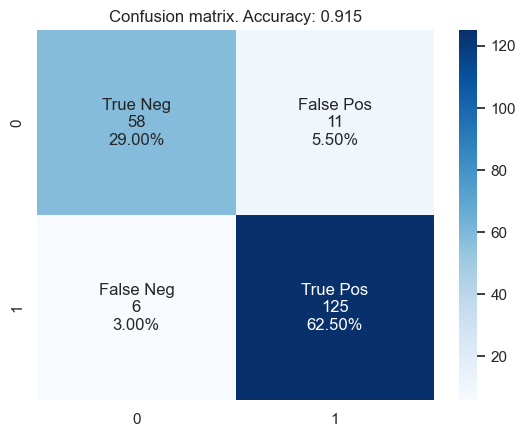

In [11]:
performance(model, X_test, y_test)